In [120]:
import numpy as np
import pandas as pd
import os
import openpyxl
import xlsxwriter
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import pylab
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings(action='once')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 2000)
pd.set_option('max_colwidth', 20)

### Sample Load & Preview

#### Description
Máte k dispozici datovou sadu anonymizovaných záznamů příchodů pacientů na urgentní příjem v nemocnici. Zadavatelem je nemocnice, která by si přála dát do rukou vrchních sester podpůrný nástroj pro plánování směn na příští den. Nemocnice sama možná ani neví, co zajímavého by se z dat ještě dalo dostat, není nutné soustředit se jen na vrchní sestry.

In [121]:
url = 'https://github.com/JanCinis/nurse-schedule-analysis/blob/main/ap2020_anonymized.xlsx?raw=true'
df = pd.read_excel(url)
df['datum a čas v sec'] = (df['datum a čas'] - datetime(2020, 1, 1)).dt.total_seconds()
print(df.info(5))   # dataset preview
df.head()           # dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   číslo              5051 non-null   int64         
 1   ročník             5051 non-null   int64         
 2   datum a čas        5051 non-null   datetime64[ns]
 3   příjat             5051 non-null   object        
 4   důvod              5051 non-null   object        
 5   odeslán            5051 non-null   object        
 6   lékař              4967 non-null   object        
 7   datum a čas v sec  5051 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 315.8+ KB
None


,číslo,ročník,datum a čas,příjat,důvod,odeslán,lékař,datum a čas v sec
0,20200001,46,2020-01-01 04:18:00,přes RZP/LSPP,bolest na hrudi,na oddělení KK,MUDr. Jan První,15480.0
1,20200002,83,2020-01-01 09:09:00,z ambulance KK IKEM,jiný,domácí ošetření,MUDr. Pavel Druhý,32940.0
2,20200003,72,2020-01-01 11:35:00,bez doporučení,palpitace,domácí ošetření,MUDr. Pavel Druhý,41700.0
3,20200004,99,2020-01-01 14:23:00,bez doporučení,bolest na hrudi,na oddělení KK,MUDr. Pavel Druhý,51780.0
4,20200005,28,2020-01-01 15:06:00,přes RZP/LSPP,jiný,na oddělení KK,MUDr. Pavel Druhý,54360.0


#### Dataset Info

- číslo (case)            - case ID, id of each threatening cases
- ročník (age)            - age of a patient
- datum a čas (datetime)  - date and time of an admission
- příjat (admission)      - from where or who sent the admission
- důvod (reason)          - the reason for visiting, disease or health problem note
- lékař (doctor)          - name of a doctor

In [122]:
#check for duplicates
print(f'number of duplicate rows is {len(df)-len(df.drop_duplicates())}')

# % of missing values in the column with missing values
mv_lekar = df['lékař'].isna().sum()*100/df['lékař'].shape[0] # where lékař is null
print(f'percentage of missing values for lékař column is {np.round(mv_lekar, 2)} %')

mv_rocnik = df[df['ročník']==0]['ročník'].count()*100/df['ročník'].shape[0] # where ročník is 0
print(f'percentage of missing values for ročník column is {np.round(mv_rocnik, 2)} %')

number of duplicate rows is 0
percentage of missing values for lékař column is 1.66 %
percentage of missing values for ročník column is 0.1 %


In [123]:
# distinct count of doctors
print(f'number of unique doctors in the dataset is {df.lékař.nunique()}')

# distinct count of cases
print(f'number of unique cases in the dataset is {df.číslo.nunique()}')

number of unique doctors in the dataset is 51
number of unique cases in the dataset is 5047


### Univariate analysis

Boxplots for numerical values, histograms for categorical values

In [124]:
dfn = df[['číslo', 'ročník', 'datum a čas v sec']]
dfn.head()

,číslo,ročník,datum a čas v sec
0,20200001,46,15480.0
1,20200002,83,32940.0
2,20200003,72,41700.0
3,20200004,99,51780.0
4,20200005,28,54360.0


In [125]:
dfc = df[['ročník', 'příjat', 'důvod', 'odeslán', 'lékař']]
dfc.head()

,ročník,příjat,důvod,odeslán,lékař
0,46,přes RZP/LSPP,bolest na hrudi,na oddělení KK,MUDr. Jan První
1,83,z ambulance KK IKEM,jiný,domácí ošetření,MUDr. Pavel Druhý
2,72,bez doporučení,palpitace,domácí ošetření,MUDr. Pavel Druhý
3,99,bez doporučení,bolest na hrudi,na oddělení KK,MUDr. Pavel Druhý
4,28,přes RZP/LSPP,jiný,na oddělení KK,MUDr. Pavel Druhý


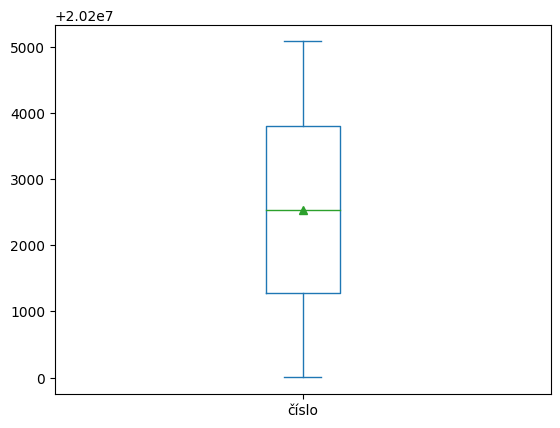

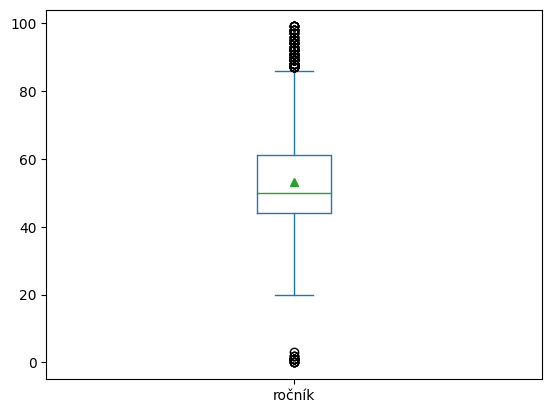

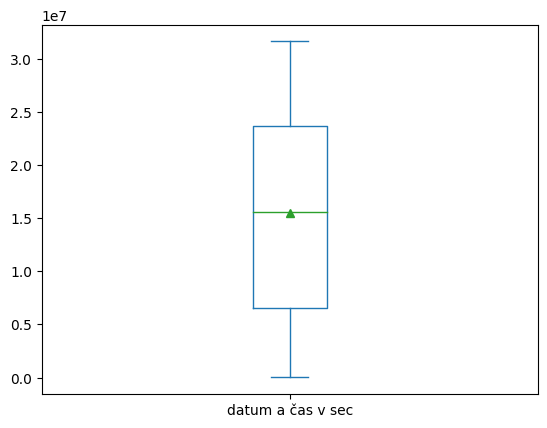

In [126]:
def boxplot_pint(df_input):
    for column in df_input:
        df_input[column].plot(kind='box', vert=True, showmeans=True)
        plt.xticks(rotation=0, ha='center')
        plt.show()
        #plt.semilogx()

boxplot_pint(dfn)

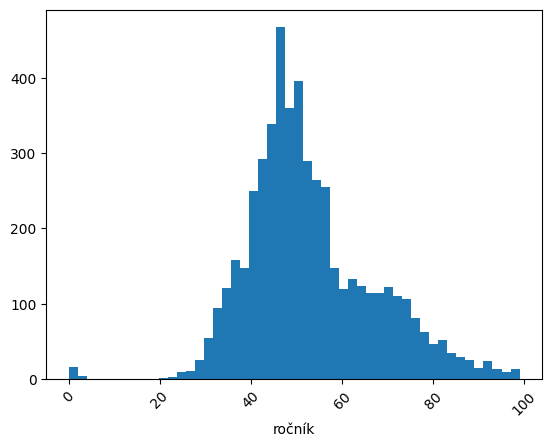

/var/folders/qg/w0wjrnfn2vncp3qq0s8t40hm0000gp/T/ipykernel_44888/1171716827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[column].dropna(how="all", inplace=True)


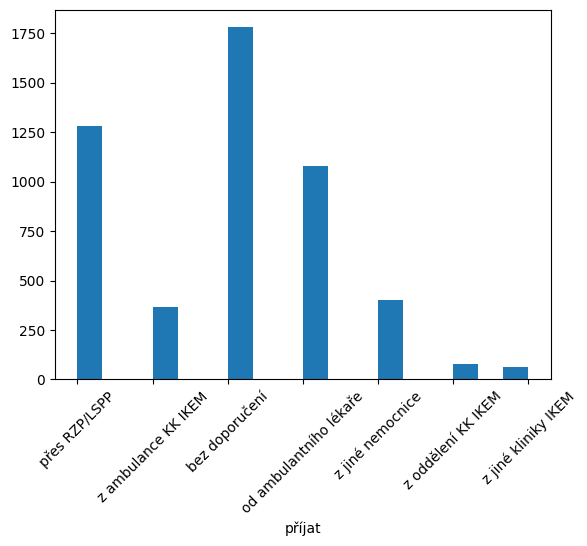

/var/folders/qg/w0wjrnfn2vncp3qq0s8t40hm0000gp/T/ipykernel_44888/1171716827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[column].dropna(how="all", inplace=True)


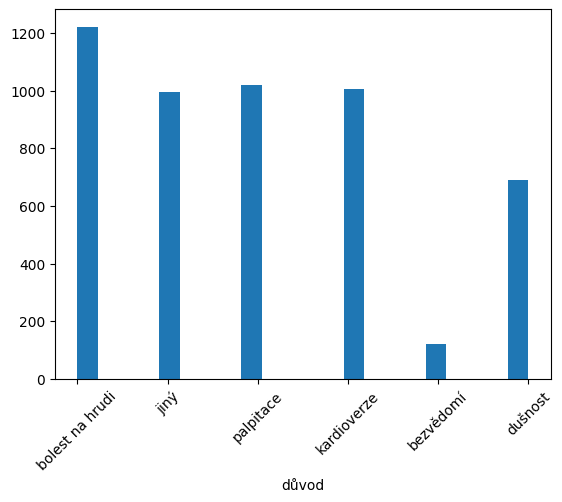

/var/folders/qg/w0wjrnfn2vncp3qq0s8t40hm0000gp/T/ipykernel_44888/1171716827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[column].dropna(how="all", inplace=True)


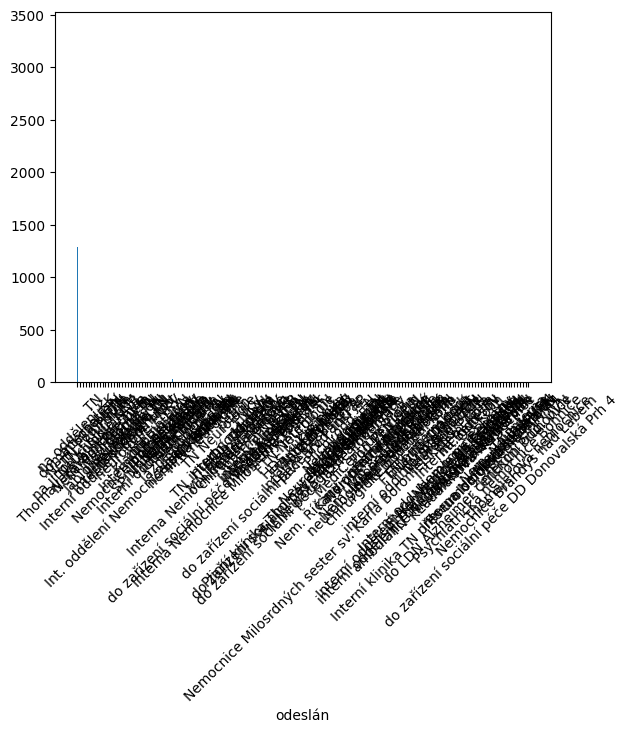

/var/folders/qg/w0wjrnfn2vncp3qq0s8t40hm0000gp/T/ipykernel_44888/1171716827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[column].dropna(how="all", inplace=True)


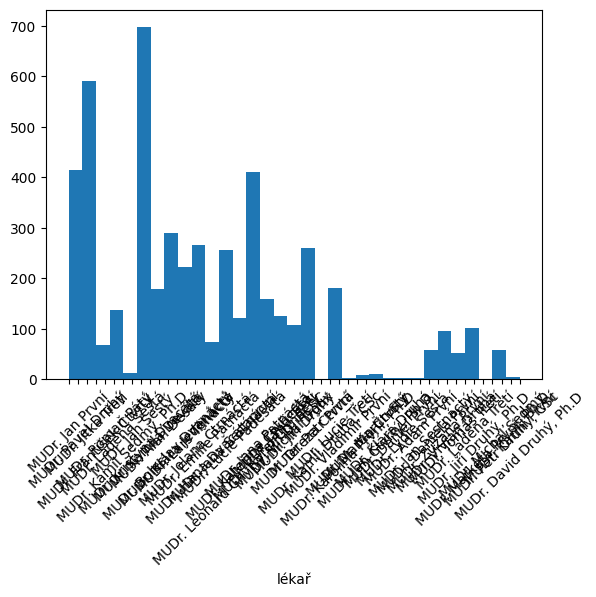

In [127]:
def histogram_pint(df_input):
    for column in df_input:
        df_input[column].replace('', np.nan)
        df_input[column].dropna(how="all", inplace=True)
        graph = df_input.loc[df_input[column].notnull(), column]
        plt.hist(graph, bins='auto')
        plt.xlabel(column)
        plt.xticks(rotation=45)
        plt.show()
        #plt.semilogx()

histogram_pint(dfc)

fix values of 'odeslán' column to make it usable as a categorical column

In [128]:
TN_kw_list = ['Thomajeŕová nemocnice', 'TN', 'thomajeŕová nemocnice', 'Thomayerova nemocnice']

for value in TN_kw_list:
     mask = df['odeslán'].str.contains(value, regex=False)
     df.loc[mask, 'odeslán'] = 'TN'

cond = df['odeslán'].value_counts()
df['odeslán'] = np.where(df['odeslán'].isin(cond.index[cond >= 90 ]), df['odeslán'], 'Ostatní')

df['odeslán'].value_counts().head(df['odeslán'].nunique())

domácí ošetření          3357
na oddělení KK           1289
TN                        180
Ostatní                   130
na jinou kliniku IKEM      95
Name: odeslán, dtype: int64

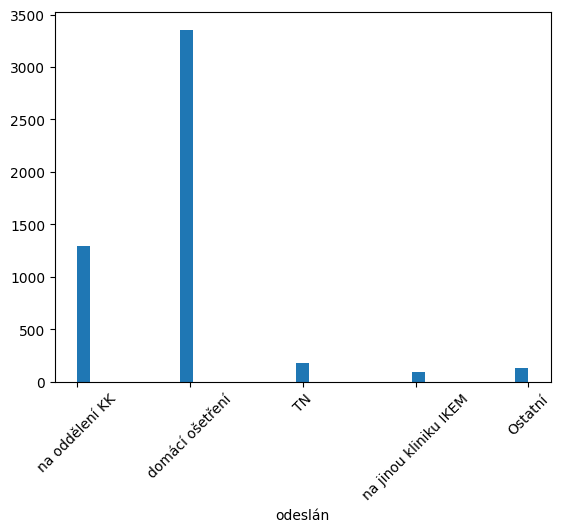

In [129]:
plt.hist(df['odeslán'], bins='auto')
plt.xlabel('odeslán')
plt.xticks(rotation=45)
plt.show()

### Multivariate analysis

avg number of doctors per week is 13.10968125123738
avg number of cases per week is 98.98119184319937
avg cases per doctor a week is 7.550236344141233


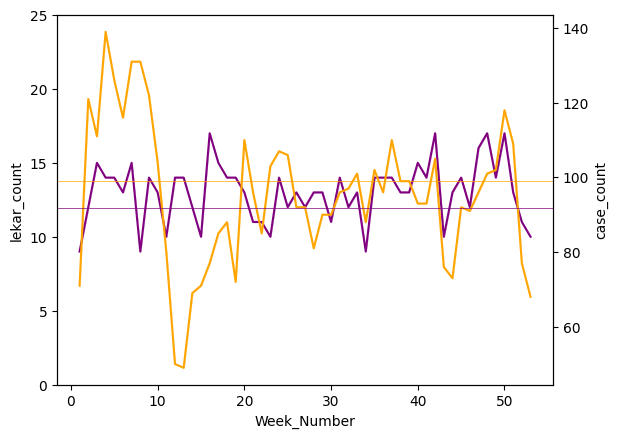

In [130]:
# lineplot analysis - Week number, Count of cases, Count of doctors
df['Week_Number'] = df['datum a čas'].dt.isocalendar().week
df['lekar_count']=df.groupby('Week_Number')['lékař'].transform('nunique')
df['case_count']=df.groupby('Week_Number')['číslo'].transform('nunique')

doctor_per_week = sns.lineplot(data=df, x='Week_Number', y='lekar_count', color='purple') #hue='case_count'
doctor_per_week.set(ylim=(0, 25))
ax2 = plt.twinx()
case_per_week = sns.lineplot(data=df, x='Week_Number', y='case_count', color='orange', ax=ax2)
ax2.axhline(df['lekar_count'].mean()*(145**2/(25*120)), color='purple', ls='-', lw=0.5)
ax2.axhline(df['case_count'].mean(), color='orange', ls='-', lw=0.5)
plt.xlabel('Week number')

print(f'avg number of doctors per week is {df.lekar_count.mean()}')
print(f'avg number of cases per week is {df.case_count.mean()}')
print(f'avg cases per doctor a week is {df.case_count.mean()/df.lekar_count.mean()}')

Conslusion: 

1. On average, patients are treated by 13 different doctors a week, and there are almost 99 threatening cases a week.
Around 7.55 cases a week per each doctor in avarage.

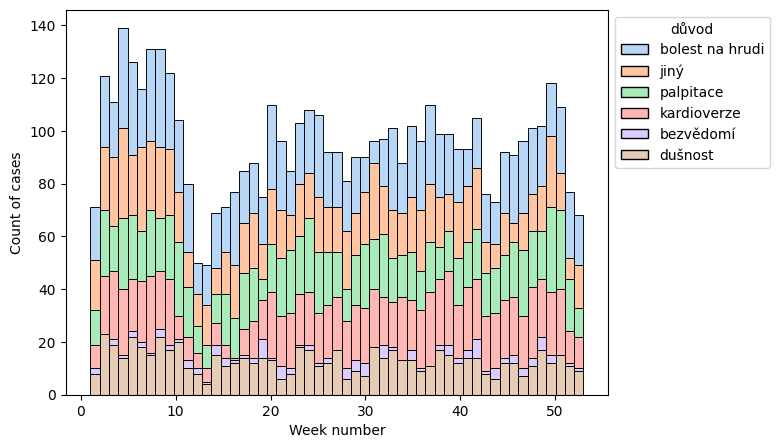

In [131]:
# histogram analysis - Week number, Count of cases, Reasons
figure = plt.figure(figsize=(7,5))
ax = figure.add_subplot(1,1,1)
sns.histplot(data=df, stat='count', multiple='stack',
             x='Week_Number', kde=False,
             palette='pastel', hue='důvod', element='bars', bins=df['Week_Number'].nunique())
ax.set_xlabel('Week number')
ax.set_ylabel('Count of cases')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Conclusion:

2. The ratio between the various reasons of cases approximately remains unchanged, unconsciousness is the least represented, but the other reasons appear regularly, their ratios differ slightly from week to week.

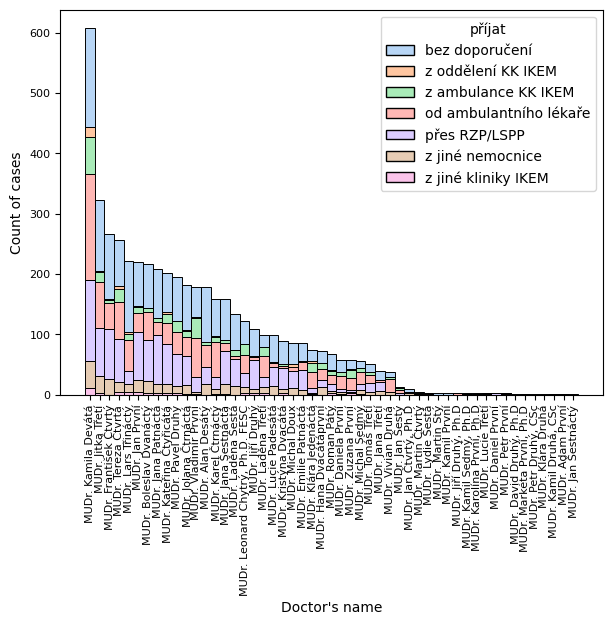

lékař                             dcotor_case_KPI_week
MUDr. Kamila Devátá               11.471698               608
MUDr. Jitka Třetí                 6.094340                323
MUDr. František Čtvrtý            5.037736                267
MUDr. Tereza Čtvrtá               4.849057                257
MUDr. Lars Třináctý               4.188679                222
MUDr. Jan První                   4.150943                220
MUDr. Boleslav Dvanáctý           4.075472                216
MUDr. Jana Patnáctá               3.943396                209
MUDr. Kateřina Čtyřicátá          3.811321                202
MUDr. Pavel Druhý                 3.679245                195
MUDr. Jolana Čtrnáctá             3.396226                181
MUDr. Vladimír První              3.377358                179
MUDr. Alan Desátý                 3.358491                178
MUDr. Karel Čtrnáctý              3.000000                159
MUDr. Jana Šestnáctá              2.981132                158
MUDr. Laděna Še

In [132]:
# histogram analysis - Count of cases, Doctors, Admission
figure = plt.figure(figsize=(7,5))
ax = figure.add_subplot(1,1,1)
df['case_per_doctor']=df.groupby('lékař')['číslo'].transform('nunique')
df_doc_sort = df.sort_values(['case_per_doctor'], ascending=False)

sns.histplot(data=df_doc_sort, stat='count', multiple='stack',
             x='lékař', kde=False,
             palette='pastel', hue='příjat', element='bars', bins=df['lékař'].nunique())
plt.xticks(rotation=90)
ax.set_xlabel('Doctor\'s name')
ax.set_ylabel('Count of cases')
ax.tick_params(labelsize=8)
plt.show()

# doctors cases KPI per week
df['dcotor_case_KPI_week'] = df['case_per_doctor'] / df['Week_Number'].nunique()
doc_KPI_table = df.groupby(['lékař', 'dcotor_case_KPI_week']).size().sort_values(ascending=False)
print(doc_KPI_table)

doc_KPI_greater_1 = df['dcotor_case_KPI_week'][df['dcotor_case_KPI_week'] >= 1].nunique()
print(f'\n number of doctors with KPI >= 1 is {doc_KPI_greater_1}')

Conclusion:

3. All doctors treat all the type of patients, no metter by admission note.
4. MUDr Kamila Devata has almost twice as many threatening cases (2x KPI) as the doctor in 2nd place in terms of KPI, this could be some kind of error in the data. This should be investigated in the next steps.
5. There are 28 doctors with a KPI greater than or equal to 1, that is 28 doctors who on average threaten at least 1 case/patient per week during the year; the remaining 23 doctors with a KPI < 1 may be considered as underused.

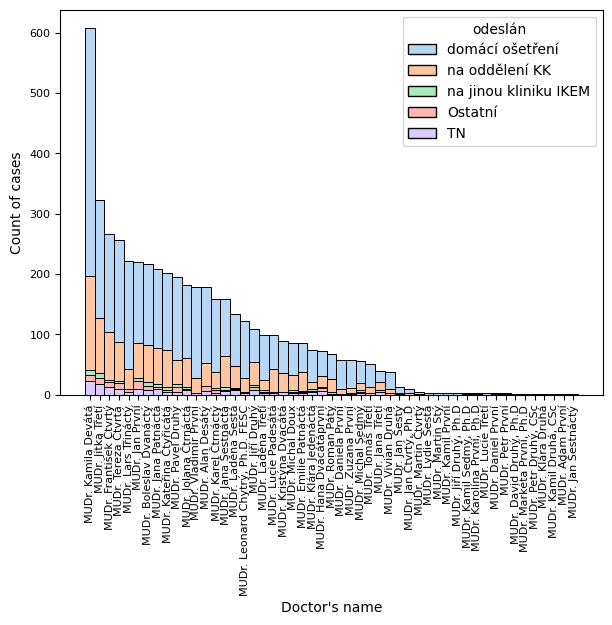

In [133]:
# histogram analysis - Count of cases, Doctors, Sent
figure = plt.figure(figsize=(7,5))
ax = figure.add_subplot(1,1,1)
sns.histplot(data=df_doc_sort, stat='count', multiple='stack',
             x='lékař', kde=False,
             palette='pastel', hue='odeslán', element='bars', bins=df['lékař'].nunique())
plt.xticks(rotation=90)
ax.set_xlabel('Doctor\'s name')
ax.set_ylabel('Count of cases')
ax.tick_params(labelsize=8)
plt.show()

Conclusion:

6. All doctors have about the same ratio in where they send patients (odeslán). Except Lars Trinacty, Vladimir Prvni, Karel Ctrnacty, Leonard Chytry and Ladena Treti they significantly have more parients that were sent home in comparing to ratio (bars) of other doctors. Reasons need to be investigated deeper for those doctors.

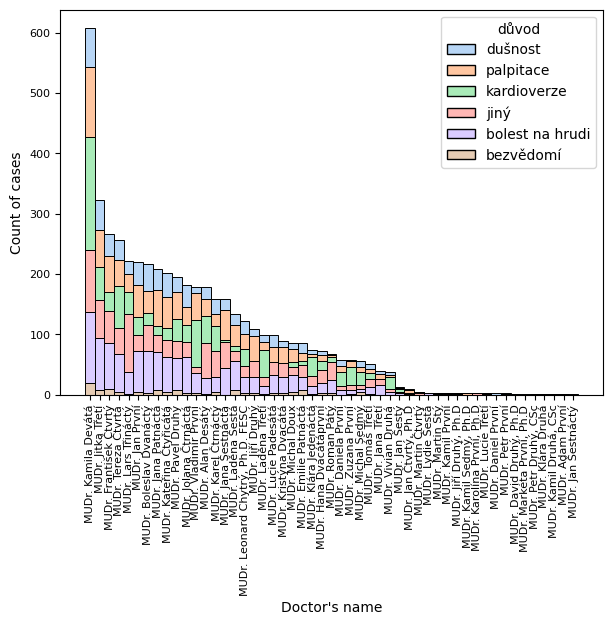

In [134]:
# histogram analysis - Count of cases, Doctors, Reason
figure = plt.figure(figsize=(7,5))
ax = figure.add_subplot(1,1,1)
sns.histplot(data=df_doc_sort, stat='count', multiple='stack',
             x='lékař', kde=False,
             palette='pastel', hue='důvod', element='bars', bins=df['lékař'].nunique())
plt.xticks(rotation=90)
ax.set_xlabel('Doctor\'s name')
ax.set_ylabel('Count of cases')
ax.tick_params(labelsize=8)
plt.show()

Conclusion:

7. The ratio for various reasons varies greatly for each doctor, most likely because of each doctor's specialty and which doctors were available in a particular week.

### Measures of variability and central tendency

In [140]:
dfn.describe()

,číslo,ročník,datum a čas v sec
count,5.051000e+03,5051.000000,5.051000e+03
mean,2.020254e+07,53.121956,1.551808e+07
std,1.466070e+03,14.126913,9.416322e+06
min,2.020000e+07,0.000000,1.548000e+04
25%,2.020127e+07,44.000000,6.557160e+06
50%,2.020254e+07,50.000000,1.559202e+07
75%,2.020381e+07,61.000000,2.364537e+07
max,2.020508e+07,99.000000,3.160650e+07


In [136]:
# skewness
print(f'skewness of ročník {df.ročník.astype(float).skew()}')

# kurtosis
print(f'kurtosis of ročník {df.ročník.astype(float).kurt()}')

skewness of ročník 0.5582037249161511
kurtosis of ročník 0.7368400074769359


In [137]:
CentralTendacy = {}

def central_tend(df_input):
    for column in df_input:
        CentralTendacy[str(column)+' Mean'] = df_input[column].mean()
        CentralTendacy[str(column)+' Median'] = df_input[column].median()
        CentralTendacy[str(column)+' Mode'] = df_input[column].mode()[0]

central_tend(dfn)
CentralTendacy

{'číslo Mean': 20202538.9928727,
 'číslo Median': 20202538.0,
 'číslo Mode': 20201779,
 'ročník Mean': 53.12195604830727,
 'ročník Median': 50.0,
 'ročník Mode': 46,
 'datum a čas v sec Mean': 15518078.938823996,
 'datum a čas v sec Median': 15592020.000000002,
 'datum a čas v sec Mode': 11519580.0}

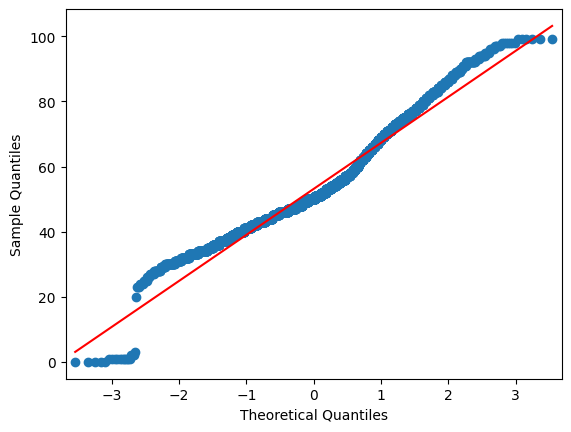

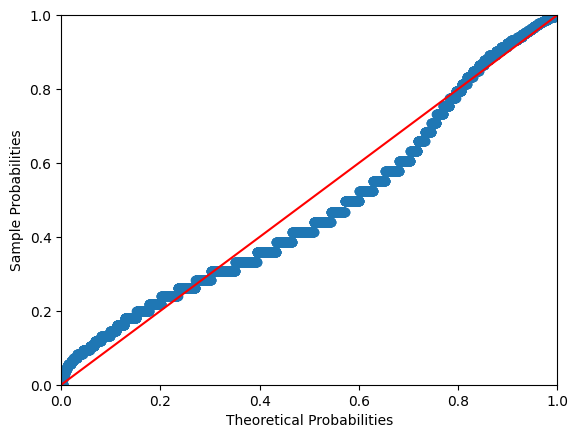

In [138]:
# Q-Q plot & P-P plot
graph = df.loc[df['ročník'].notnull(), 'ročník']
sm.qqplot(graph, line='s')
pylab.show()

pplot = sm.ProbPlot(graph, stats.t, fit=True)
pplot.ppplot(line='45')
pylab.show()

Conclusion:

8. The distribution of interest is only age (ročník), but by visual judgment and descriptive statistics (mean, median, mode, stdev) we can say that this distribution is not like normal. But more methods can be used to prove this.

### Conclusion list

0. There are 5 variables in the data set, see their description at the beginning. There are 51 doctor names and 5,047 distinct threatening cases (číslo) in this sample. Also of all rows, there are 1.66% of records with a missing doctor name, which cannot be imputed because it is a categorical variable. The percentage of missing values for the column patient age (ročník) is 0.1%, which can be solved by simple mean/median imputation, as the percentage of missing values is not significant < 1%.
1. On average, patients are treated by 13 different doctors a week, and there are almost 99 threatening cases a week.
Around 7.55 cases a week per each doctor in avarage.
2. The ratio between the various reasons of cases approximately remains unchanged, unconsciousness is the least represented, but the other reasons appear regularly, their ratios differ slightly from week to week.
3. All doctors treat all the type of cases/patients, no metter by admission note.
4. MUDr Kamila Devata has almost twice as many threatening cases (2x KPI) as the doctor in 2nd place in terms of KPI, this could be some kind of error in the data. This should be investigated in the next steps.
5. There are 28 doctors with a KPI greater than or equal to 1, that is 28 doctors who on average threaten at least 1 case/patient per week during the year; the remaining 23 doctors with a KPI < 1 may be considered as underused.
6. All doctors have about the same ratio in where they send patients (odeslán). Except Lars Trinacty, Vladimir Prvni, Karel Ctrnacty, Leonard Chytry and Ladena Treti they significantly have more parients that were sent home in comparing to ratio (bars) of other doctors. Reasons need to be investigated deeper for those doctors.
7. The ratio for various reasons varies greatly for each doctor, most likely because of each doctor's specialty and which doctors were available in a particular week.
8. The distribution of interest is only age (ročník), but by visual judgment and descriptive statistics (mean, median, mode, stdev) we can say that this distribution is not like normal. But more methods can be used to prove this.

### EDA recommendations and insights for building a support tool for planning shifts for the next day (podpůrný nástroj pro plánování směn na příští den)

Insights for creating a model:

I. In average there are about 7.5 threatening cases a week per doctor, with avg. 13 doctors treating these patients during the week. Design the parameters of cases & doctors time slots. Also, it should not be forgotten that 1.66% of the values of the doctor names were missing from the dataset.

II. The model should reflect the higher threatening cases load approx. from weeks 3 to 7 at the beginning of the year, and around week 50 at the end of the year. Some decrease in patient/cases load can be expected at about 12-13 weeks.

III. In order to plan and manage doctors' workload, we should implement a KPI parameter. See as example dcotor_case_KPI_week, also see conclusion 5.

IV. Before building the model, we should understand why the doctor with the highest KPI has such a gap in the KPI over the rest doctors, and whether it is caused by an error in the data or not. We also need to understand why 23 doctors have less than 1 patient/case per week during the year, and whether they have appropriate duties for patients like doctors with KPIs > 1.

V. This is not as useful for the model, but since the hospital is a client of the project, we can pass on as additional information about the abnormalities found. This refers to the 5 doctors from Conclusion 6. who send patients home more often compared to other doctors. There is nothing wrong with this, it is just a detail that has been noticed.

VI. The distribution of ročník does not seem to be normal.